In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [9]:
def Exact_NEIM(mu, f, U, max_modes = 25):
    """
    Compute a non-neural network NEIM for solution
    independent nonlinearities.
    
    mu: parameters
    f:  nonlinearity corresponding to each mu in a matrix
    U:  POD basis
    """
    
    Pf = U.T @ f # projection of f
    
    selected_parameters = []
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    idx = np.argmax([np.linalg.norm(Pf[:, i])**2 for i in range(Pf.shape[1])])
    mu_1 = mu[idx]
    selected_parameters.append(mu_1)
    selected_indices.append(idx)
    
    NN_1 = np.copy(Pf[:, [idx]])
    NN_1 /= np.linalg.norm(NN_1)
    trained_networks.append(NN_1)
    thetas = np.array([np.dot(NN_1.reshape(-1), Pf[:, i])/np.linalg.norm(NN_1)**2 for i in range(Pf.shape[1])])
    current_approximation = thetas * NN_1
    
    # NEIM Update Step
    for i in range(1, max_modes):
        idx = np.argmax([np.linalg.norm(current_approximation[:, i] - Pf[:, i])**2 for i in range(Pf.shape[1])])
        mu_i = mu[idx]
        selected_parameters.append(mu_i)
        selected_indices.append(idx)
        
        # orthogonalize selected vector with respect to previous vectors
        NN_i = Pf[:, [idx]]
        for network in trained_networks:
            NN_i -= np.dot(NN_i.reshape(-1), network.reshape(-1)) * network / np.linalg.norm(network)**2
        NN_i /= np.linalg.norm(NN_i)
        
        trained_networks.append(NN_i)
        A = np.zeros((i+1, i+1))
        for j in range(A.shape[0]):
            for k in range(A.shape[1]):
                A[j, k] = np.dot(trained_networks[j].reshape(-1), trained_networks[k].reshape(-1))
        
        thetas = []
        for j in range(Pf.shape[1]):
            b = np.zeros((i+1, 1))
            for k in range(b.shape[0]):
                b[k, 0] = np.dot(trained_networks[k].reshape(-1), Pf[:, j])
            thetas.append(np.linalg.solve(A, b).reshape(-1))
        thetas = np.array(thetas).T
        current_approximation = np.array(trained_networks)[:, :, 0].T @ thetas
    
    trained_networks = np.array(trained_networks)[:, :, 0].T
    
    def Exact_NEIM_approximation(new_mu, num_modes=-1):
        if num_modes == -1:
            num_modes = trained_networks.shape[1]
        thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='cubic').reshape(-1, 1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='nearest').reshape(-1, 1)
        return U @ (trained_networks[:, :num_modes] @ thetas_[:num_modes])
    
    return Exact_NEIM_approximation, selected_indices

In [4]:
def NEIM(f):
    """
    Compute NEIM approximation for
    parameters mu and snapshots f.
    """
    
    raise NotImplementedError

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathcal{D}\to\mathbb{R}$ defined by $$s(x;\mu) = (1-x)\cos(3\pi\mu(x+1))e^{-(1+x)\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{D} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equidistantly spaced points in $\Omega$ for $i=1,\dots,n$, $n=100$. Define $f:\mathcal{D}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1;\mu),\dots,s(x_n;\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{D}$. 

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

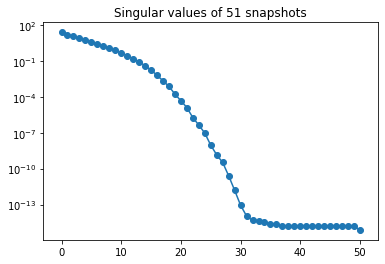

In [5]:
def s(x, mu):
    return (1-x)*np.cos(3*np.pi*mu*(x+1))*np.exp(-(1+x)*mu)

x = np.linspace(-1, 1, 100).reshape(-1,1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

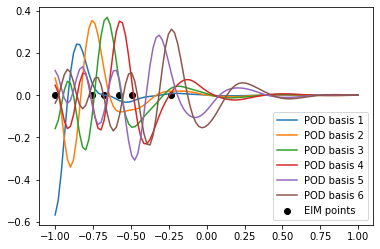

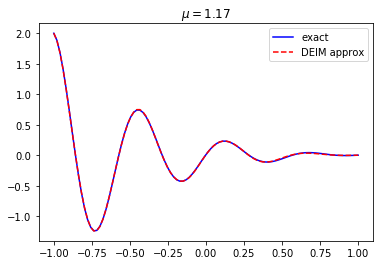

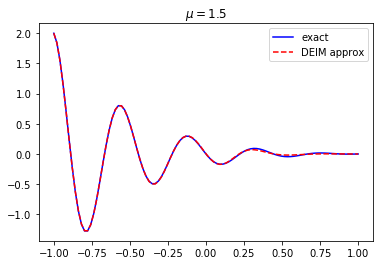

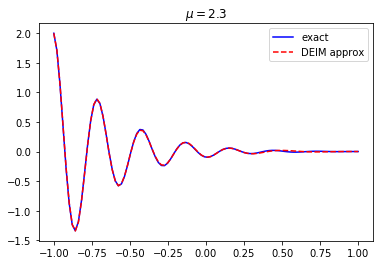

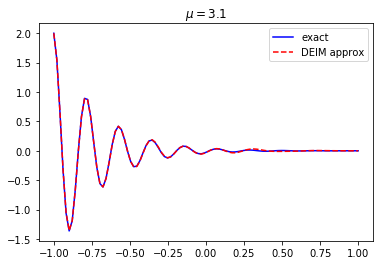

In [6]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    exact = s(x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for POD, DEIM, Exact NEIM
Exact NEIM is the version of NEIM for nonlinearities which do not depend on solutions (they depend on space and parameters). In this case, NEIM should approximate constant vectors in its expansion, so we instead use these exact vectors.

**If you want better results for Exact NEIM, increase NUM_TRAIN_PARAMS**

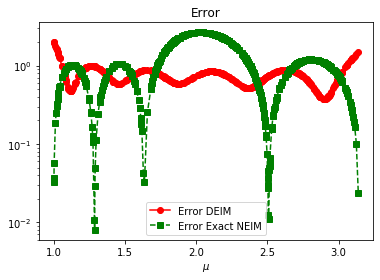

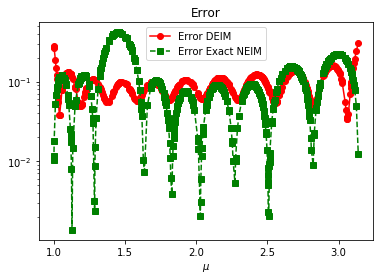

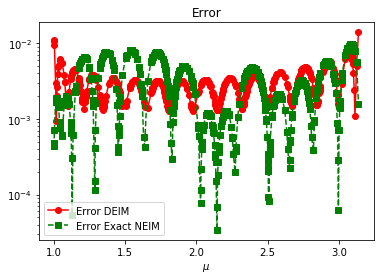

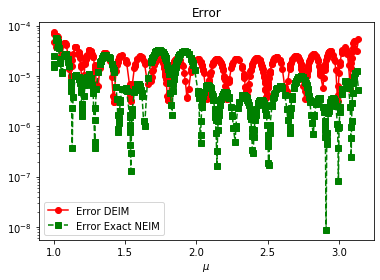

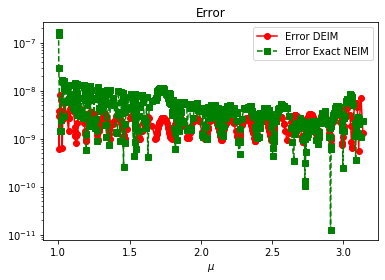

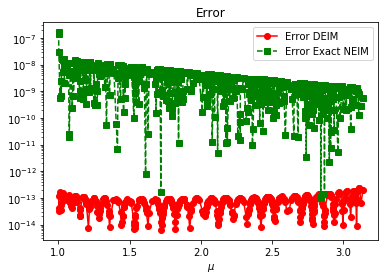

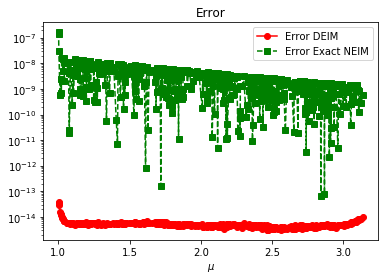

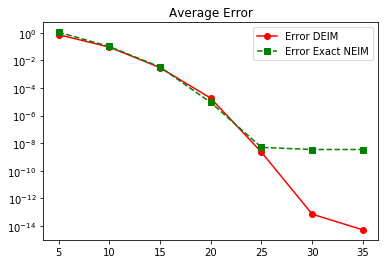

In [24]:
MAX_MODES = 35
NUM_TRAIN_PARAMS = 501
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

test_mu = np.sort(np.random.uniform(size=501)*(np.pi-1)+1)
#test_mu = np.linspace(1, np.pi, 534).reshape(-1, 1).T
DEIM_errors = []
POD_errors = []
Exact_NEIM_errors = []
for num_modes in range(5, MAX_MODES+1, 5):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    Exact_NEIM_approximation, NEIM_selected_indices = Exact_NEIM(mu.reshape(-1), f, u, num_modes)

    exact = s(x, test_mu)
    DEIM_approximation = DEIM_proj @ exact
    POD_approximation = u[:, :num_modes] @ u[:, :num_modes].T @ exact
    Degenerate_NEIM_approximation = np.array([Exact_NEIM_approximation(new_mu, num_modes) for new_mu in test_mu.reshape(-1)])[:, :, 0].T
        
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])])
    #POD_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Exact_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', c='r', label="Error DEIM")
    #plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])], marker='^', c='black', linestyle='dotted', label="Error POD")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.show()
    

#print(DEIM_errors, "\n", POD_errors, "\n", Exact_NEIM_errors)    

plt.plot(np.arange(5, MAX_MODES+1, 5), DEIM_errors, marker='o', c='r', label="Error DEIM")
#plt.plot(np.arange(5, MAX_MODES+1, 5), POD_errors, marker='^', c='black', linestyle='dotted', label="Error POD")
plt.plot(np.arange(5, MAX_MODES+1, 5), Exact_NEIM_errors, marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
plt.yscale("log")
plt.legend()
plt.title("Average Error")
plt.show()

# It is important that there are sufficiently many parameters for training NEIM...